# Notebook to analyze various statistics of the labeled events
# Furthermore, the events were visually inspected in the labeling notebooks to ensure their quality

## Import and Initialize Everything

In [80]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5py
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import math
import pdb
import scipy
# Add project path to path for import
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

# Add module path to path for import
module_path = os.path.abspath("../data_utility/data_utility.py")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_utility import CREAM_Day # class to work with a day of the CREAM Dataset
import seaborn as sns
%load_ext autoreload
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Import some graphical modules
from IPython.display import display, clear_output
from ipywidgets import Button, Layout, ButtonStyle, HBox, VBox, widgets, Output
from IPython.display import SVG, display, clear_output
%matplotlib widget
import subprocess
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
PATH_TO_DATA = os.path.abspath(os.path.join("..", "..", "Datasets", "CREAM"))
ALL_DAYS = ["2018-08-23" , "2018-08-24" , "2018-08-25",  "2018-08-26" , "2018-08-27" , "2018-08-28" ,
"2018-08-29", "2018-08-30", "2018-08-31", "2018-09-01", "2018-09-02" , "2018-09-03" ,  "2018-09-04" ,
"2018-09-05", "2018-09-06", "2018-09-07", "2018-09-08" , "2018-09-09" , "2018-09-10", "2018-09-11", "2018-09-12" 
"2018-09-13" ,"2018-09-14" ,"2018-09-15" ,  "2018-09-16", "2018-09-17", "2018-09-18","2018-09-19"  , "2018-09-20" ,
"2018-09-21" , "2018-09-22" ,  "2018-09-23" ,"2018-09-24" ,"2018-09-25" ,"2018-09-26" , "2018-09-27", "2018-09-28" ,
"2018-09-29" , "2018-09-30" , "2018-10-01" ,"2018-10-02" , "2018-10-03" ,"2018-10-04", "2018-10-05" , "2018-10-06" ,
"2018-10-07", "2018-10-08" ]

## Load the Event Files

In [3]:
#necessary for the plotting
# Load the events 
day_path = os.path.join(PATH_TO_DATA, "2018-08-24") #arbitrary day to initialize the object
current_CREAM_day = CREAM_Day(cream_day_location=day_path,use_buffer=True, buffer_size_files=2) 

# Load the electrical component events (the raw ones)
all_component_events = current_CREAM_day.load_component_events(os.path.join(PATH_TO_DATA, "component_events.csv"), filter_day=False)

# Load the product and the maintenance events (the raw ones, per minute events) and filter for the day
all_maintenance_events = current_CREAM_day.load_machine_events(os.path.join(PATH_TO_DATA, "maintenance_events.csv"), raw_file=False, filter_day=False)
all_product_events = current_CREAM_day.load_machine_events(os.path.join(PATH_TO_DATA, "product_events.csv"), raw_file=False, filter_day=False)


# Analyze the Event Types

#### Display the different event types and labeled components, together with their cardinality

In [4]:
for events_df in [all_maintenance_events, all_product_events]:  
    print(events_df.Event_Type.value_counts())
    print("-------------------------------------")
all_component_events.Component.value_counts()

MillingPlantEspresso    1316
MillingPlantCoffee      1008
RinseMilkSystem          418
CleanMilkSystem           47
Time2Clean                47
RinseCoffeeSystem         22
Clean                      9
Time2Descale               1
Name: Event_Type, dtype: int64
-------------------------------------
cappuccino            521
coffee                361
espresso              313
hot_water             157
latte_macchiato       109
white_coffee           10
ristretto               3
espresso_macchiato      2
Name: Event_Type, dtype: int64
-------------------------------------


unlabeled       89989
heater           1988
pump              260
millingplant      212
Name: Component, dtype: int64

### Functions necessary to do so

In [5]:
def plot_event_durations(events_df:pd.DataFrame, event_type_column: str = "Event_Type", nominal_times_per_event=dict):
    """
    Function to plot the event duration, for every event type.
    Parameters
    ----------
    events_df (pd.DataFrame): maintenance events or product events dataframe
    event_type_column (str): Name of the column containing the event type. 
    nominal_times_per_event (dict): dictionary containing the nominal times per event from the manual of the coffee maker
    
    Returns
    -------
    
        
    """
                               
    for e_type in np.unique(events_df[event_type_column]):
        x = events_df[events_df[event_type_column] == e_type].Event_Duration_Seconds
        
        n_samples = len(events_df[events_df[event_type_column] == e_type])
        mean = np.mean(x)
        stdev = np.std(x)
        
        
        # if existent, plot the nominal times from the manual with a red line
        if nominal_times_per_event[e_type] is not None:
            nominal_event_time = nominal_times_per_event[e_type] / 2
            #lt.axvline(nominal_event_time, color="red")
            deviation = np.abs((nominal_times_per_event[e_type] / 2) - mean)
        
        else:
            deviation = 9999
            
        sns.distplot(x, label=e_type)
        plt.legend()
        plt.show()

def print_event_duration_statistics(events_df:pd.DataFrame, event_type_column: str = "Event_Type"):
    """
    Function to print the event duration, for every event type.
    Parameters
    ----------
    events_df (pd.DataFrame): maintenance events or product events dataframe
    event_type_column (str): Name of the column containing the event type. 
    
    Returns
    -------
    
        
    """
    
    data = { "event type" : [],
        "samples": [],
           "mean" : [],
           "standard deviation" : []}
    
                               
    for e_type in np.unique(events_df[event_type_column]):
        x = events_df[events_df[event_type_column] == e_type].Event_Duration_Seconds
        
        n_samples = len(events_df[events_df[event_type_column] == e_type])
        mean = np.mean(x)
        stdev = np.std(x)
        
        data["samples"].append(n_samples)
        data["mean"].append(mean)
        data["standard deviation"].append(stdev)
        data["event type"].append(e_type)
    data = pd.DataFrame(data)
    data = data.sort_values(["samples"], ascending=False)
    print(data.to_latex())
       

#### When looking at the durations of the individual event types, we can also look at the nominal durations from the coffee maker manual.
#### We devide these times by 2, as they give the times per two products of the same type in the official manual.
#### These times deviate from the ones recorded due to various reasons:
#### 1. The system settings regarding water usage, milling duration, ... etc. alter the time per product
#### 2. The user can influence the durations by, for example, stopping the product making process earlier then expected.
#### 3. The labeling introduces some inaccuracies potentially. 
#### We want to investigate all these influence in sum.


In [6]:
NOMINAL_TIMES_PER_EVENT = {'cappuccino' : 75, 
                     'coffee' : 63,
                     'espresso' : 48, 
                     'espresso_macchiato' : 110,
                     'hot_water' : 50, 
                     'latte_macchiato' : 110, 
                     'ristretto' : 33,
                     'white_coffee' : 95,
                     'Clean' : 20 * 60,
                      'CleanMilkSystem' : None,
                      'MillingPlantCoffee' : None, 
                      'MillingPlantEspresso' : None, 
                      'RinseCoffeeSystem' : None, 
                      'RinseMilkSystem' : None,
                      'Time2Clean' : None, 
                      'Time2Descale' : 50 * 60}

## Product Events

### Event Durations

In [140]:
print_event_duration_statistics(all_product_events, "Event_Type")
print_event_duration_statistics(all_maintenance_events, "Event_Type")

\begin{tabular}{llrrr}
\toprule
{} &          event type &  samples &       mean &  standard deviation \\
\midrule
0 &          cappuccino &      521 &  50.258333 &            3.509401 \\
1 &              coffee &      361 &  29.428492 &            3.241208 \\
2 &            espresso &      313 &  23.434275 &            3.079317 \\
4 &           hot\_water &      157 &  24.161795 &            6.329412 \\
5 &     latte\_macchiato &      109 &  46.096448 &            8.399669 \\
7 &        white\_coffee &       10 &  29.859640 &            0.935597 \\
6 &           ristretto &        3 &  21.290364 &            1.991528 \\
3 &  espresso\_macchiato &        2 &  37.790312 &            1.064532 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrr}
\toprule
{} &            event type &  samples &        mean &  standard deviation \\
\midrule
3 &  MillingPlantEspresso &     1316 &    4.531531 &            1.651443 \\
2 &    MillingPlantCoffee &     1008 &    4.992558 &            1.928393 \\


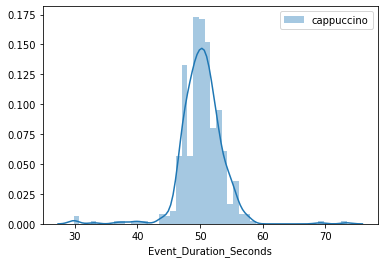

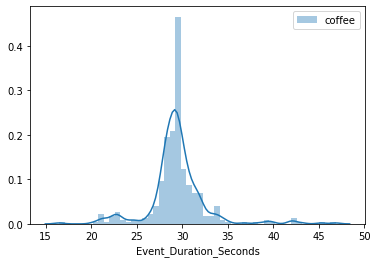

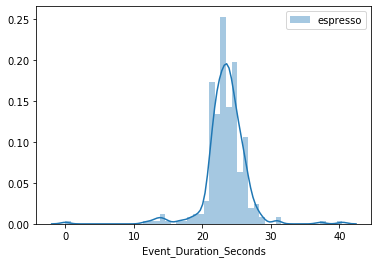

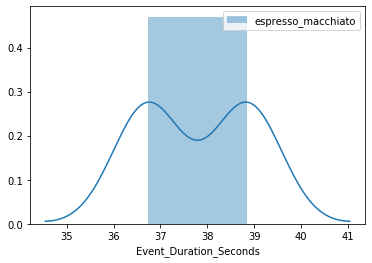

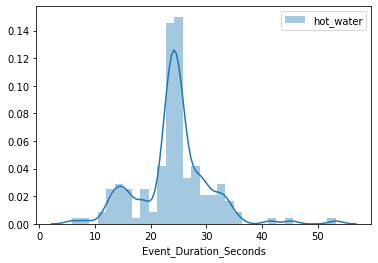

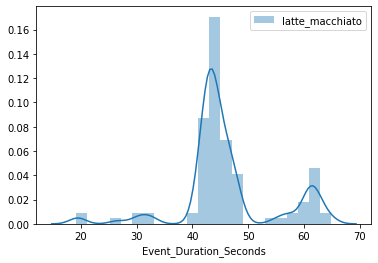

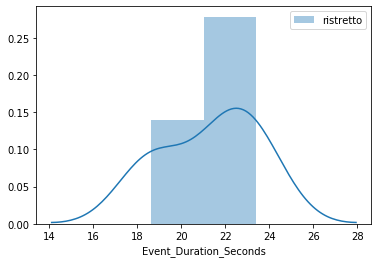

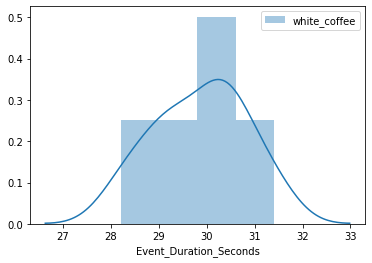

In [141]:
plot_event_durations(all_product_events, "Event_Type", NOMINAL_TIMES_PER_EVENT)

## Maintenance Events

### Event Durations

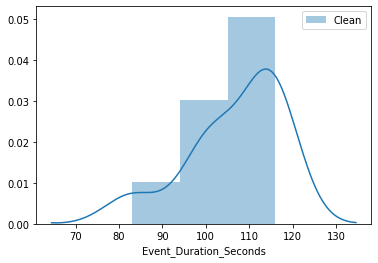

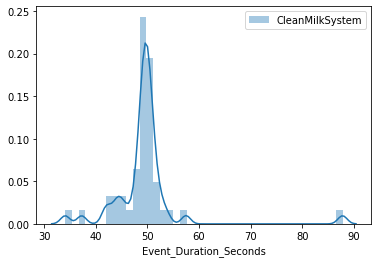

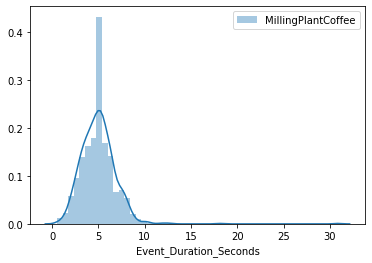

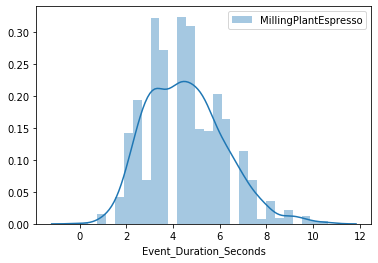

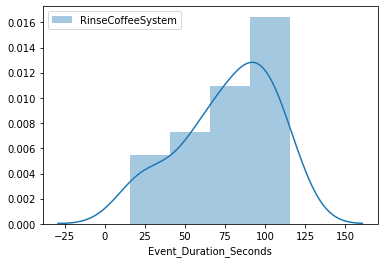

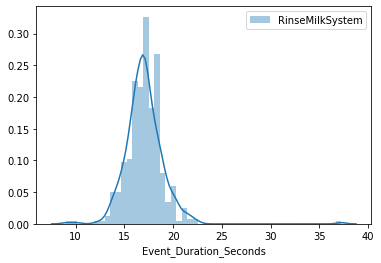

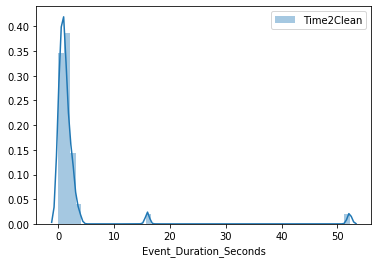

/Users/daniel/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


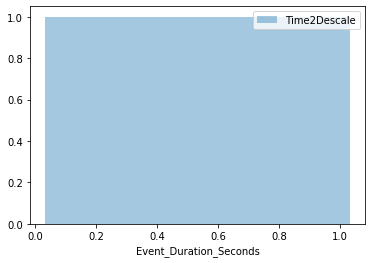

In [142]:
plot_event_durations(all_maintenance_events, "Event_Type", NOMINAL_TIMES_PER_EVENT)

# Event Distribution per Hour

In [121]:
def create_time_bin(hours : float, minutes : float) -> str:
    """
    Creates a hour:minutes timestamp, ceiled to full 30 minutes.
    All minutes below 15, become 0.
    All between 15 and 45 minutes, become 30 minutes.
    All minutes between 45 and 60 become 0 and belong to the next hour.
    """
    if minutes < 15:
        minutes = "00"
    elif minutes >= 15 and minutes < 45:
        minutes = "30"
    elif minutes >= 45:
        minutes = "00"
        hours += 1
    
    if hours < 10:
        hours = "0" + str(hours)
    else:
        hours = str(hours)
    
    return hours + ":" + minutes

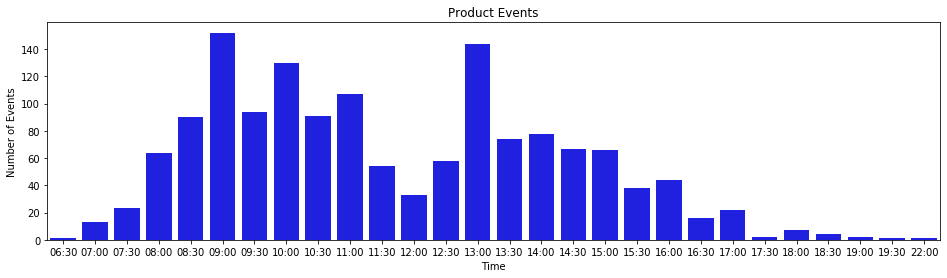

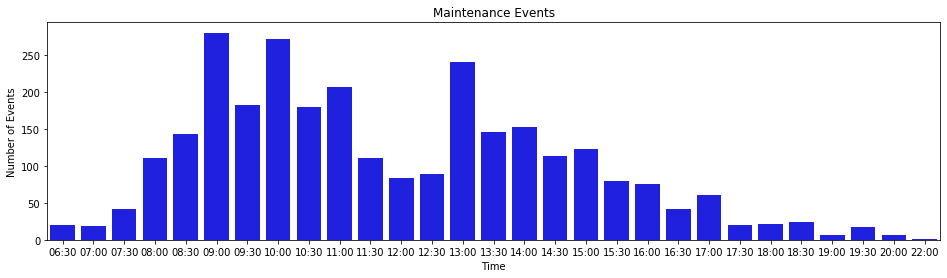

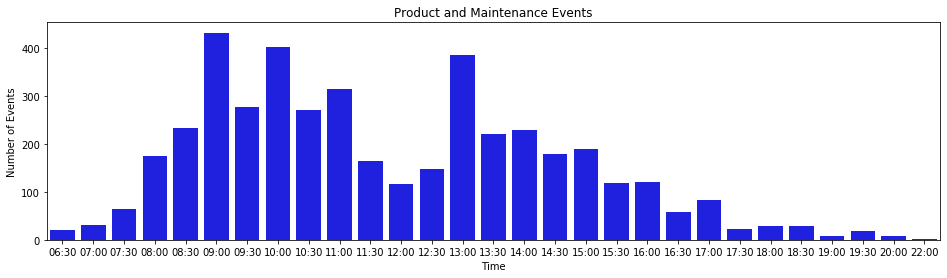

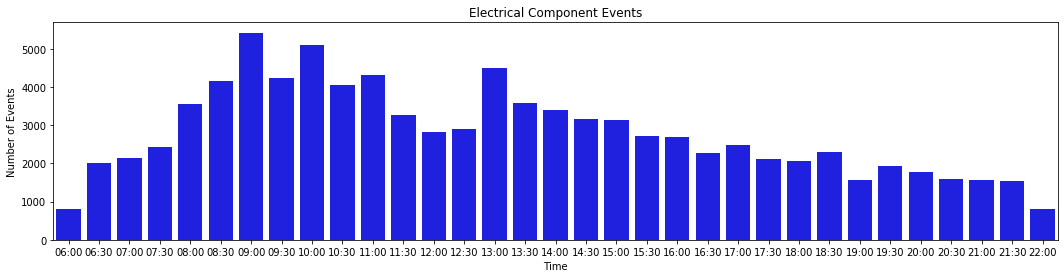

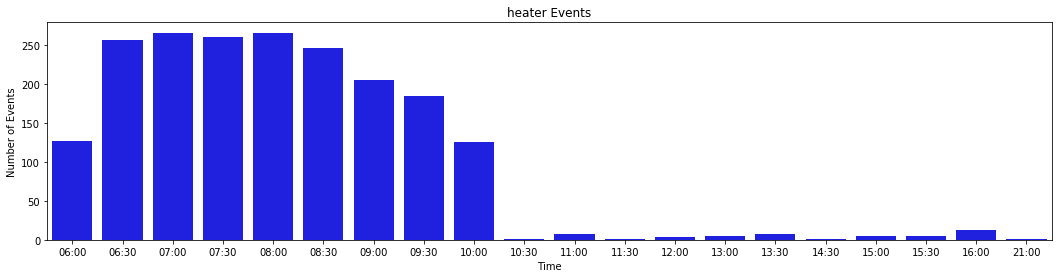

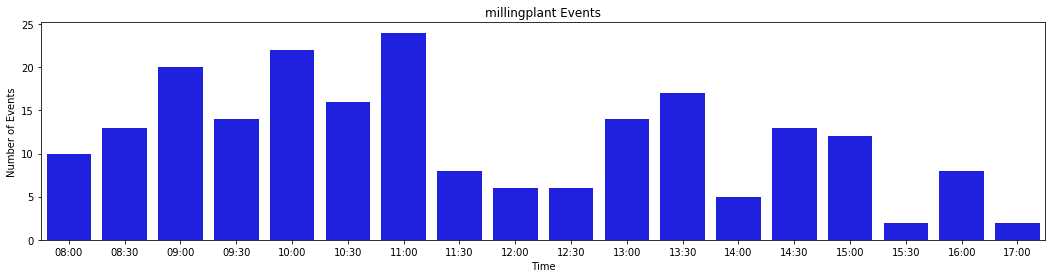

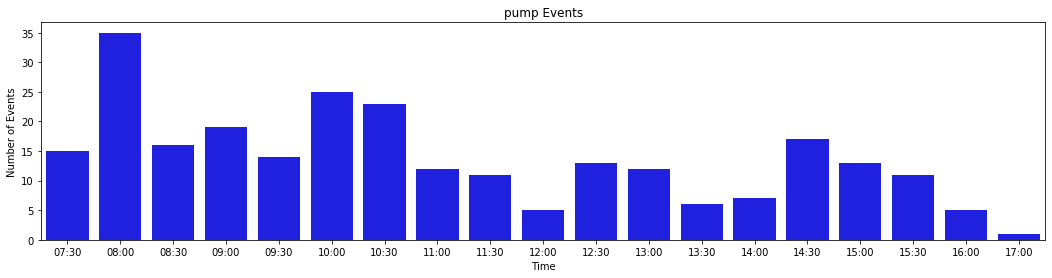

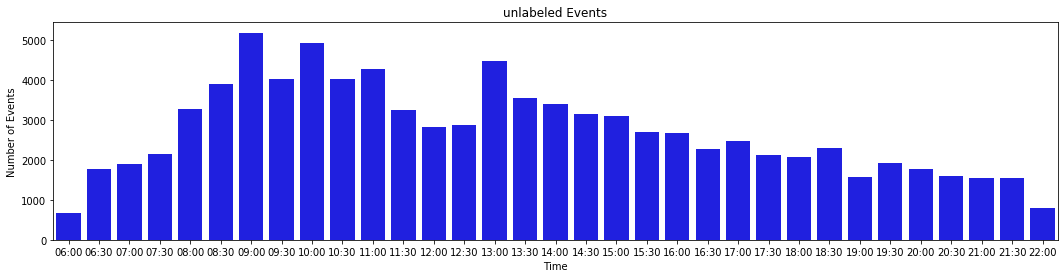

In [122]:
# create a new column with: hour:30, hour:0 in it for the x-axis as the labels
all_product_events["Time_Bin"] = all_product_events.Start_Timestamp.apply(lambda x: create_time_bin(x.hour, x.minute))

times, counts = np.unique(all_product_events["Time_Bin"], return_counts=True)

plt.figure(figsize=(16,4))
plt.title("Product Events")
plt.xlabel("Time")
plt.ylabel("Number of Events")
sns.barplot(x=times, y=counts, color="b")
plt.show()

# create a new column with: hour:30, hour:0 in it for the x-axis as the labels
all_maintenance_events["Time_Bin"] = all_maintenance_events.Start_Timestamp.apply(lambda x: create_time_bin(x.hour, x.minute))

times, counts = np.unique(all_maintenance_events["Time_Bin"], return_counts=True)

plt.figure(figsize=(16,4))
plt.title("Maintenance Events")
plt.xlabel("Time")
plt.ylabel("Number of Events")
sns.barplot(x=times, y=counts,color="b")
plt.show()

# create a new column with: hour:30, hour:0 in it for the x-axis as the labels
all_maintenance_events["Time_Bin"] = all_maintenance_events.Start_Timestamp.apply(lambda x: create_time_bin(x.hour, x.minute))
all_product_events["Time_Bin"] = all_product_events.Start_Timestamp.apply(lambda x: create_time_bin(x.hour, x.minute))

times, counts = np.unique(np.concatenate([all_product_events["Time_Bin"],all_maintenance_events["Time_Bin"]]), return_counts=True)

plt.figure(figsize=(16,4))
plt.title("Product and Maintenance Events")
plt.xlabel("Time")
plt.ylabel("Number of Events")
sns.barplot(x=times, y=counts,color="b")
plt.show()


fontdict_text = {"size" : 18}
# create a new column with: hour:30, hour:0 in it for the x-axis as the labels
all_component_events["Time_Bin"] = all_component_events.Timestamp.apply(lambda x: create_time_bin(x.hour, x.minute))

times, counts = np.unique(all_component_events["Time_Bin"] , return_counts=True)

plt.figure(figsize=(18,4))
plt.title("Electrical Component Events")
plt.xlabel("Time", fontdict=fontdict_text)
plt.ylabel("Number of Events", fontdict=fontdict_text)
plt.xticks(fontdict=fontdict_text)
sns.barplot(x=times, y=counts,color="b")
plt.show()

for component in np.unique(all_component_events.Component):
    component_events = all_component_events[all_component_events.Component == component].Timestamp.apply(lambda x: create_time_bin(x.hour, x.minute))
    times, counts = np.unique(component_events, return_counts=True)
    plt.figure(figsize=(18,4))
    plt.title(component + " Events")
    plt.xlabel("Time")
    plt.ylabel("Number of Events")
    sns.barplot(x=times, y=counts,color="b")
    plt.show()

## Electrical Component Events

## Mean instantenous power of the components

In [10]:
mean_instant_power_list = []
component_list = []
x_axis = [] # x-axis, first component at 1, second at 2, third at 3
for index, component in enumerate( np.unique(all_component_events.Component), start=1):
    if component == "unlabeled": #skip the unlabeled ones
        continue
        
    component_events = all_component_events[all_component_events.Component == component]
    
    component_events = component_events.sample(n=100, random_state=10)
    # for efficienfy reasons, iterate over each day separately
    for day_date in np.unique(component_events.Date):
              
        for event in component_events[component_events.Date == day_date].itertuples():
            cream_day = CREAM_Day(cream_day_location=os.path.join(PATH_TO_DATA, str(day_date)), use_buffer=True, buffer_size_files=10)
            voltage, current = cream_day.load_time_frame(event.Timestamp, duration=0.5, return_noise=False)
            instant_power = voltage * current
            mean_instant_power_list.append(np.mean(instant_power))
            component_list.append(component)
            x_axis.append(index)
    


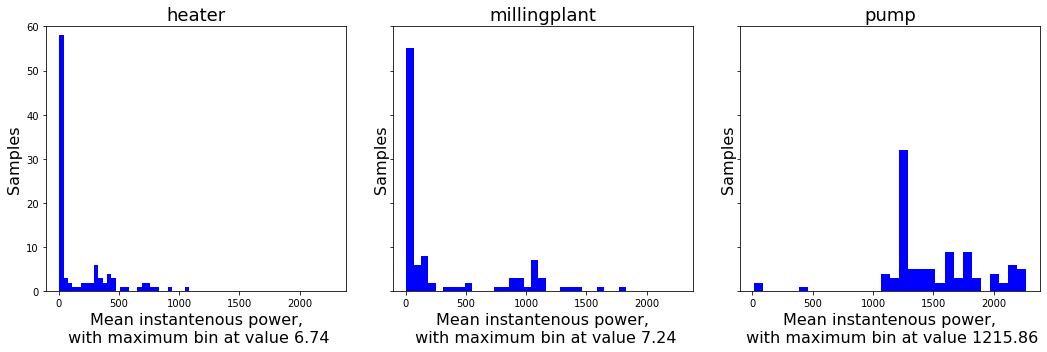

In [125]:
import matplotlib
%matplotlib inline
component_list = np.array(component_list)
mean_instant_power_list = np.array(mean_instant_power_list)
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
#matplotlib.rcParams.update({'font.size': 10})
for i, component in enumerate(np.unique(component_list)):
    mask = np.where(component_list == component)[0]
    hist, bins = np.histogram(mean_instant_power_list[mask], bins=30)
    biggest_bin = np.argmax(hist) # get biggest bin and its value
    x, y, _ = ax[i].hist(mean_instant_power_list[mask], bins, color="b")
   
    max_bin = np.argmax(x)
    max_value = y[max_bin]
    
   # ax[i].set_xticklabels(y)
    
    ax[i].set_title(component, fontsize=18)
    ax[i].set_ylim(0,60)
    ax[i].set_ylabel("Samples", fontsize=16)
    ax[i].set_xlabel("Mean instantenous power,\n with maximum bin at value %.2f" %(max_value), fontsize=16)
    
fig.tight_layout()
plt.show()
fig.savefig("./component_mean_instant_power.pdf")